In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
from flask_sqlalchemy import SQLAlchemy
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split # for #2
from sklearn.model_selection import cross_val_score # for #3
import matplotlib.pyplot as plt
import warnings
import os
%matplotlib inline

warnings.filterwarnings("ignore") #, category=DeprecationWarning)

In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

# the values of those depend on your setup
POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

# app.config['SQLALCHEMY_DATABASE_URI'] = DB_URL
# app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False # silence the deprecation warning

# db = SQLAlchemy(app)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
# TODO Fix SQL input/output; temp fix:
df = pd.read_pickle('data/kickstarter_data.pkl')

In [6]:
print(df.shape)
df.head()

(19291, 20)


,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,campaign_length,pct_goal_achieved,main_category_code,country_code,currency_code,state_code
ID,,,,,,,,,,,,,,,,,,,,
1031685482,You Sparkle Inside: A Kids' Book + Commissions...,Children's Books,Publishing,USD,2018-01-02,2000.0,2017-12-06,6083.00,successful,133,US,1054.0,6083.00,2000.0,27 days,304.150000,12,21,13,1
1176736360,THE NEW BILLY WYLDER RECORD,Indie Rock,Music,USD,2018-01-02,10000.0,2017-11-30,11169.56,successful,177,US,650.0,11169.56,10000.0,33 days,111.695600,10,21,13,1
1894703097,Driftwood Holly ***The Venice Project***,Indie Rock,Music,EUR,2018-01-02,25000.0,2017-11-28,25417.20,successful,168,DE,0.0,30615.02,30112.5,35 days,101.668809,10,5,4,1
311863059,On a Limb's debut album,Jazz,Music,USD,2018-01-02,1000.0,2017-12-09,1743.00,successful,39,US,0.0,1743.00,1000.0,24 days,174.300000,10,21,13,1
2076121120,Briggs Barbecue Sauces,Small Batch,Food,USD,2018-01-02,200000.0,2017-11-03,1.00,failed,1,US,0.0,1.00,200000.0,60 days,0.000500,7,21,13,0


In [8]:
X = df[['main_category_code','country_code','currency_code','usd_goal_real']]
y = df['state_code']

k_range = list(range(1, 101))
print(X.shape)
print(y.shape)

(19291, 4)
(19291,)


## Logistic Regression

In [9]:
from patsy import dmatrices

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [10]:
y,X=dmatrices('state_code~ main_category_code + country_code + currency_code + usd_goal_real',data=df,return_type='dataframe')

In [11]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

Training Data Accuracy: 0.57
Test Data Accuracy:     0.56
[[2173    0]
 [1686    0]]


Precision:              0.56
Recall:                 1.00


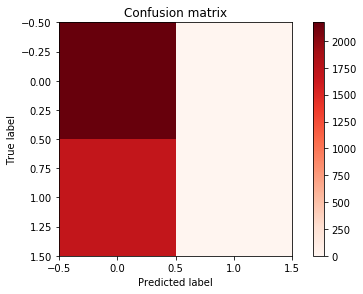

In [12]:
log_clf=LogisticRegression()
train_score(log_clf,X,y)

Text(0,0.5,'TPR')

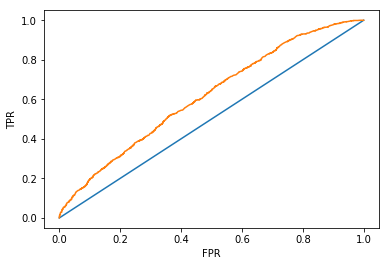

In [13]:
# What about ROC ? 

from sklearn.metrics import roc_curve, auc

xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)
log = LogisticRegression()
log.fit(xtrain,np.ravel(ytrain))
y_score=log.predict_proba(xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [14]:
# consider adding confusion matrix cost-benefits example